# Simulating life history

To simulate individual life history, we use the `ODE_simulator`. <br>
It takes a single positional argument `p`, which is a parameter vector 
provided as `ComponentArray`. <br>
To get started more easily, `AmphiDEB` provides a default parameter set.

In [1]:
using Pkg; Pkg.activate(".");
using AmphiDEB # load AmphiDEB

p = deepcopy(AmphiDEB.defaultparams) # get a copy of the default parameters

  Activating project at `c:\Users\Simon\Documents\Julia\AmphiDEB\examples`


ComponentVector{Any}(glb = (t_max = 56.0, N0 = 1.0, dX_in = Any[20.0, 20.0], k_V = Any[0.0, 0.0], V_patch = Any[1.0, 1.0], T = 293.15, C_W = Any[0.0], pathogen_inoculation_dose = 0.0, pathogen_inoculation_time = 30.0, medium_renewals = Any[0.0]), pth = (gamma = 0.0010000000000000002, eta = 8.0, v0 = 0.5, f = 0.5, sigma0 = 0.16666666666666666, sigma1 = 0.16666666666666666, mu = 0.01986754966887417), spc = (Z = Distributions.Dirac{Float64}(value=1.0), propagate_zoom = (dI_max_emb = 0.3333333333333333, dI_max_lrv = 0.3333333333333333, dI_max_juv = 0.3333333333333333, X_emb_int = 1.0, H_j1 = 1.0, H_p = 1.0, K_X_lrv = 0.3333333333333333, K_X_juv = 0.3333333333333333), X_emb_int = 1, K_X_lrv = 1.0, K_X_juv = 1.0, dI_max_emb = 1, dI_max_lrv = 1, dI_max_juv = 1, kappa_emb = 0.8, kappa_juv = 0.8, gamma = 0.5, eta_IA = 0.54, eta_AS_emb = 0.4, eta_AS_juv = 0.4, eta_AR = 0.95, eta_SA = 0.8, k_M_emb = 0.11, k_M_juv = 0.11, k_J_emb = 0.027, k_J_juv = 0.027, H_j1 = 1, H_p = 55.0, T_A = 8000.0, T_ref 

To simulate individual life history, we plug the parameter vector into the `ODE_simulator`:

In [2]:
sim = AmphiDEB.ODE_simulator(p)
first(sim, 3)

┌ Warning: Using arrays or dicts to store parameters of different types can hurt performance.
│ Consider using tuples instead.
└ @ SciMLBase C:\Users\Simon\.julia\packages\SciMLBase\JKXkh\src\performance_warnings.jl:33


Row,t,X_1,X_2,C_W_1,N,aging_mortality,starvation_mortality,GUTS_mortality,P_Z,N_emb,N_lrv,N_mt,N_juv,N_ad,embryo,juvenile,adult,X_emb,S,H,R,f_X,I_emb,I,A,M,J,D_j_1_1,D_j_1_2,D_j_1_3,D_j_1_4,D_j_1_5,D_j_1_6,D_j_1_7,D_h_1,y_T,y_j_1_1,y_j_1_2,y_j_1_3,y_j_1_4,y_j_1_5,y_j_1_6,y_j_1_7,h_z,S_z,S_max_hist,id,cohort,age,cause_of_death,time_since_last_repro,cum_repro,larva,metamorph,E_mt,E_mt_max,P_S,y_jP_1,y_jP_2,y_jP_3,y_jP_4
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,20.0,20.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.001,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.001,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0e-10,1.0e-10,0.0,1.0,1.0,1.0,1.0
2,1.0,40.0,40.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.977947,0.00694902,0.00123134,0.0,0.0,0.0,0.0220531,0.0119087,0.00037664,1.32087e-5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.001,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0e-10,1.0e-10,0.0,1.0,1.0,1.0,1.0
3,2.0,60.0,60.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.923462,0.0201236,0.00440074,0.0,0.0,0.0,0.0765381,0.0413306,0.00179654,8.39829e-5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.001,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0e-10,1.0e-10,0.0,1.0,1.0,1.0,1.0


The output is, by default, a `DataFrame` containing state variables over time. <br>
The `AmphiDEB.ODE_simulator` in AmphiDEB is a simple wrapper around `EcotoxSystems.ODE_simulator` with different defaults.

## Modifying input parameters

To change the model parameters, we need to modify entries in the parameter vector `p`. <br>

In `AmphiDEB`, a parameter vector consists of three components:

- `glb`: These are global parameters (forcings), such as the simulated time span, food addition rates, etc.
- `spc`: These are species-specific parameters, essentially the DEB and TKTD parameters, plus some auxiliary parameters. 
- `pth`: These are growth and infection parameters of the pathogen. The pathogen module largely follows the density-dependent variant of the model described by [Drawert et a. (2017)](https://royalsocietypublishing.org/doi/full/10.1098/rsif.2017.0480).

We can, for example, simulate a different the food input rate by modifying `p.glb.dX_in`. <br>
This entry is a two-parameter vector, since we have a food input rate for aquatic and terrestric stages, respectively.

In [3]:
p.glb.dX_in = [10., 30.]
sim = AmphiDEB.ODE_simulator(p);

We have confirmation that the food input rates were in fact changed by inspecting the output columns `X_1` and `X_2`, respectively 
(these names are assigned automatically by the function `ComponentArrays.labels`).

In [4]:
first(sim, 3)[:,[:t, :X_1, :X_2]]

Row,t,X_1,X_2
,Float64,Float64,Float64
1,0.0,10.0,30.0
2,1.0,20.0,60.0
3,2.0,30.0,90.0


## Simulating chemical effects

<div style="border: 1px solid; background-color:rgb(64, 0, 255); padding: 10px; border-radius: 5px; color: #ffffff;">
  <strong>Caveats:</strong> <br>
  - In this version of AmphiDEB (v0.3.3), the TKTD module will only affect aquatic life stages. <br>
  - Only constant exposure is natively supported through the default `AmphiDEB.ODE_simulator` (use callbacks for pulsed exposures)
</div>

 The sublethal TKTD parameters are stored in matrices, where each column corresponds to one physiological mode of action (PMoA), 
  and each row corresponds to one chemical stressor. <br>

  The default TKTD parameters imply no chemical effects at all.

The PMoAs have a fixed order in the parameter matrices:

1. Decrease in growth efficiency ($G$)
2. Increase in somatic and maturity maintenance costs ($M$)
3. Decrease in assimilation efficiency ($A$)
4. Decrease in reproduction efficiency ($R$)
5. Decrease in maturity threshold for metamorphosis ($H^-$)
6. Increase in maturity threshold for metamorphosis ($H^+$)
7. Decreased investment in growth/increased investment in maturation ($\kappa^-$)


The default `AmphiDEB` model assumes a log-logistic relationship between scaled damge $D_{z,j}$ and the response $y_{z,j}$ to stressor $z$ with respect to PMoA $j$.<br>

The meanings of the TKTD parameters are than as follows:

- `KD`: Dominant rate constants
- `E`: Median effective damages
- `B`: Slopes

For PMoAs with increasing response (e.g. maintenance costs), a damage value equal to the median effective damage causes an relative increase of $1-ln 0.5 \approx 1.7$.

Finally, to simulate chemical effects, we first set the TKTD parameters to the desired values. <br>
The syntax `KD[1,2]` means that we set the $k_D$-value for the second PMoA ($M$) of the first stressor.

In [5]:
p.spc.KD[1,2] = 1. # engage the second PMoA (M) for the first stressor
p.spc.E[1,2] = 1. # set median effective damage 
p.spc.B[1,2] = 1. # set slope value

1.0

Then, we define a vector of (constant) aquatic exposure concentrations.

In [6]:
C_W = [0., 0.5, 1., 2.];

The `exposure` function takes care of the rest.

In [7]:
sim = AmphiDEB.exposure(
    AmphiDEB.ODE_simulator,
    p, 
    C_W
);

Let's plot the results, using recipes provided by `EcotoxSystems.jl` (we can import these directly from `AmphiDEB` without having to import `EcotoxSystems` explicitly).

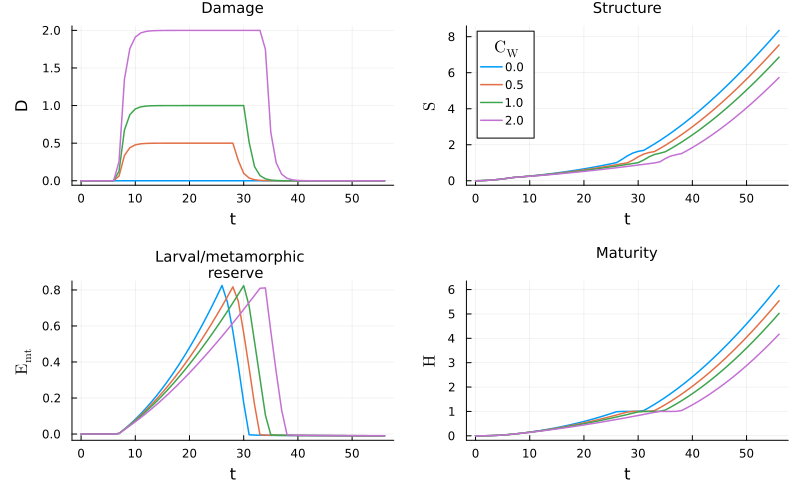

In [ ]:
using Plots.Measures, StatsPlots, LaTeXStrings
import AmphiDEB: groupedlineplot
default(leg = false, lw = 1.5)

@df sim plot(
    groupedlineplot(:t, :D_j_1_2, :treatment_id, title = "Damage", ylabel = "D"),
    groupedlineplot(:t, :S, :treatment_id, title = "Structure", ylabel = L"\mathsf{S}", leg = :topleft, label = hcat(C_W...), legendtitle = L"\mathsf{C_W}"), 
    groupedlineplot(:t, :E_mt, :treatment_id, ylabel = L"\mathsf{E^{mt}}", title = "Larval/metamorphic \n reserve"), 
    groupedlineplot(:t, :H, :treatment_id, title = "Maturity", ylabel = L"\mathsf{H}"), 
    groupedlineplot(:t, :X_emb, :treatment_id, title = "Vitellus", ylabel = L"\mathsf{X_{emb}}"),
    xlabel = "t", titlefontsize = 10, size = (800,500), leftmargin = 5mm, bottommargin = 5mm
)

So, what do we see in the figure above? <br>
Damage starts at 0 and remains there for several days. This is the embryonic development phase, as can also be seen in the plot for the vitellus (embryonic buffer) $X^{emb}$. There is no part in the TKTD module that allows for embryos to accumulate damage. <br>

This is followed by a phase of damage accumulation, stagnation and elimination. <br>
The elimination pase is triggered by the beginning of metamorphic climax ($\approx$ Gosner stage 42), at which point aquatic exposure ends. <br>
Because the end of exposure is triggered by the life stage and not a fixed time point, the time point at which exposure ends also differs between treatments. This is not unusual for life-history tests with amphibians, and certainly relevant for field scenarios if chemical exposure is primarily aquatic.

By the way, we can also use Julia's `less` function to quickly get a look into a function definition. <br>
The default TKTD module in `AmphiDEB` is `TKTD_LL2!`, which uses a two-parameter log-logistic relationship to link damage to physiological response.

In [124]:
less(AmphiDEB.TKTD_LL2!)

@inline function TKTD_LL2!(du, u, p, t)::Nothing
    
    @unpack glb, ind = u

    ind.y_j .= 1.0 # reset relative responses 
    ind.h_z = p.ind[:h_b] # reset GUTS-SD hazard rate to background mortality

    for z in eachindex(glb.C_W) # for every chemical
        for j in eachindex(ind.y_j) # for every PMoA
            # calculate change in damage
            du.ind.D_j[z,j] = minimal_TK_aquatic(ind[:larva], p.ind.KD[z,j], glb.C_W[z], ind.D_j[z,j]) 
            # update relative response with respect to PMoA j
            # PMoAs with decreasing response
            if !(j in [2,6]) 
                ind.y_j[j] *= LL2(ind.D_j[z,j], p.ind.E[z,j], p.ind.B[z,j])
            # PMoAs with increasing response
            else
                ind.y_j[j] *= LL2pos(ind.D_j[z,j], p.ind.E[z,j], p.ind.B[z,j])
            end
        end
        # calculate change in damage for lethal effects
        du.ind.D_h[z] = minimal_TK_aquatic(ind[:larva], p.ind[:KD_h][z], glb[:C_W][z], ind[:D_h][z]) 
   

The alternative would be `AmphiDEB.TKTD_linear!` (also printed above), which uses the common linear-with-threshold relationship adopted from GUTS.<br>
In that case, the parameters $\mathbf{E}$ are the thresholds and $\mathbf{B}$ are the slopes. 

## Including individual variability

This functionally is provided through [`EcotoxSystems.jl`](https://github.com/SimonHansul/EcotoxSystems.jl), but will be briefly reviewed here. <br>
Any element of the parameter vector `p` can also be provided as a distribution. <br>

### Zoom factor 

By default, we use the mass-based zoom factor `Z` to induce individual variability in the simulations:

In [25]:
using Distributions
p.spc.Z = Truncated(Normal(1, 0.2), 0, Inf)

Truncated(Normal{Float64}(μ=1.0, σ=0.2); lower=0.0, upper=Inf)

The zoom factor is here defined as the ratio between the maximum structural masses of two organisms

$$
Z = \frac{S_{max,2}}{S_{max,1}}
$$

Note that this deviates from the definition by [Kooijman (2008)](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1469-185X.2008.00053.x?casa_token=F-W1RUM1l6IAAAAA:IJaBl-cNlZpUlXPIa7LeYzqOilfoBL9t1HNONwkpVL5wxhN-Gc8tXjopXNsH4cGBUhEScgRSIKrdgYl0Zw), which is on the basis of length. <br>
However, the model formulation in `AmphiDEB.jl` expresses all state variables in the same dimension (mass or energy), and it therefore makes sense to define the zoom factor based on the same dimension. 

Because maximum structural mass depends on the surface area-specific ingestion rate $\{ \dot{I}_{max} \} $, we can use $Z$ to correct for differences in size:

$$
\{ \dot{I}_{max,2} \} = Z \cdot \{ \dot{I}_{max,1} \}^{1/3}
$$

So why do we calculate $Z$ in the first place, instead of applying the correction directly to $\{ \dot{I}_{max} \}$? <br>
Because there are more parameters which should scale with size, such as the size of eggs and maturity thresholds. <br>
These are listed in `spc.propagate_zoom`:

In [26]:
p.spc.propagate_zoom

ComponentVector{Any,SubArray...}(dI_max_emb = 0.3333333333333333, dI_max_lrv = 0.3333333333333333, dI_max_juv = 0.3333333333333333, X_emb_int = 1.0, H_j1 = 1.0, H_p = 1.0, K_X_lrv = 0.3333333333333333, K_X_juv = 0.3333333333333333)

The entry itself defines the scaling exponent to be applied (we recognize the $1/3$ from the equation above in the entries for `dI_max_emb`, `dI_max_lrv` and `dI_max_juv`). <br>

With the zoom factor set to a truncated Normal distribution, we can now repeadetly call the simulator and will get a slightly different outcome each time.

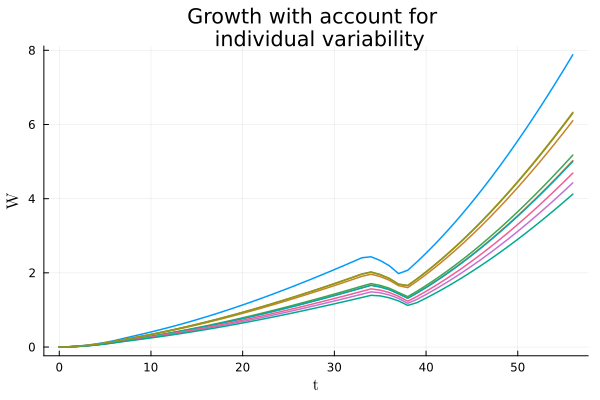

In [35]:
plt = plot()

# for some number of individuals
for _ in 1:10
    # run the simulation
    sim = AmphiDEB.ODE_simulator(p)
    # plot total dry mass over time
    @df sim plot!(plt, :t, :S .+ :E_mt, xlabel = L"\mathsf{t}", ylabel = L"\mathsf{W}", title = "Growth with account for \n individual variability")
end

plt

There is an easier way to do this, using the `@replicates` macro from `EcotoxSystems.jl`:

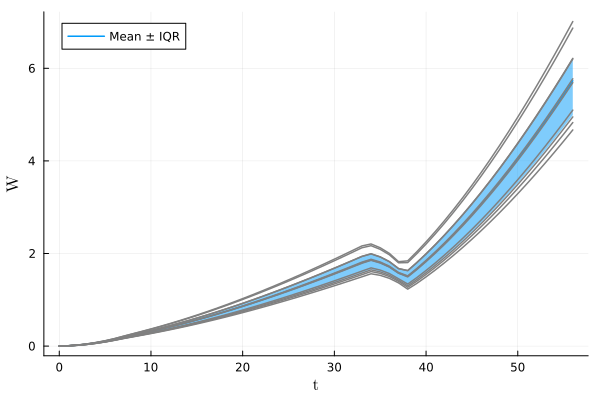

In [36]:
import AmphiDEB: @replicates, lineplot, groupedlineplot!
sim = @replicates AmphiDEB.ODE_simulator(p) 10

@df sim lineplot(:t, :S .+ :E_mt, (0.25, 0.75), leg = true, label = "Mean ± IQR", xlabel = L"\mathsf{t}", ylabel = L"\mathsf{W}")
@df sim groupedlineplot!(:t, :S .+ :E_mt, :replicate, color = :gray, label = "")

In some cases, it might be more appropriate to disengage the propagation of the zoom factor to some of the listed parameters. <br> 
We can do so by setting the corresponding entry in `spc.propagate_zoom` 0, as done here for the maturity threshold for metamorphosis. <br>

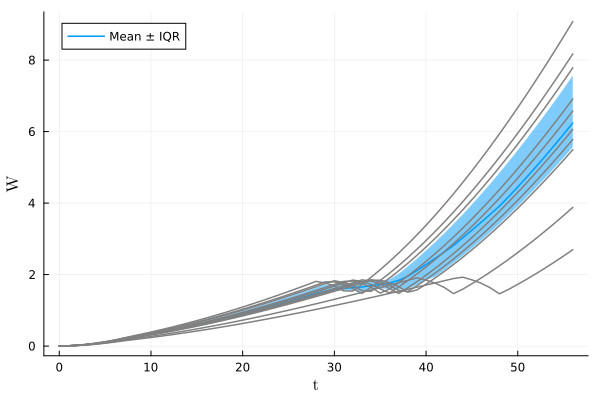

In [37]:
p.spc.propagate_zoom.H_j1 = 0.
sim = @replicates AmphiDEB.ODE_simulator(p) 10

@df sim lineplot(:t, :S .+ :E_mt, (0.25, 0.75), leg = true, label = "Mean ± IQR", xlabel = L"\mathsf{t}", ylabel = L"\mathsf{W}")
@df sim groupedlineplot!(:t, :S .+ :E_mt, :replicate, color = :gray, label = "")

Any other parameter can also be defined as a distribution. <br>
For example, we can repeat the previous simulation of chemical exposure with variability in the median effective damages.

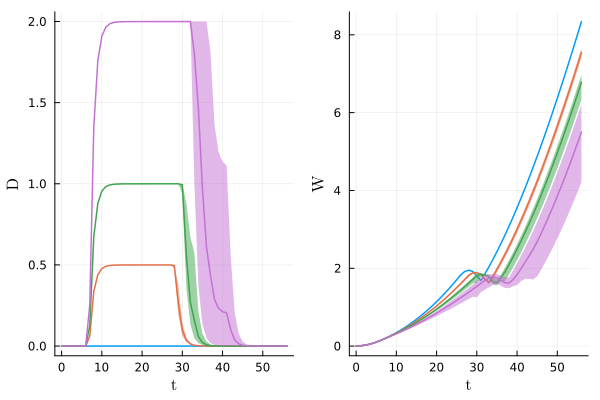

In [57]:
p.spc.Z = Dirac(1.)
p.spc.E[1,2] = truncated(Normal(1, 0.2), 0, Inf)

sim = AmphiDEB.exposure(
    p -> @replicates(AmphiDEB.ODE_simulator(p), 10), 
    p,
    C_W
    )


@df sim plot(
    groupedlineplot(:t, :D_j_1_2, :treatment_id, xlabel = L"\mathsf{t}", ylabel = L"\mathsf{D}"),
    groupedlineplot(:t, :S .+ :E_mt, :treatment_id, xlabel = L"\mathsf{t}", ylabel = L"\mathsf{W}")
)

It should be noted that this way of introducing variability between parameter simulations is not inteded to be used for uncertainty propagation.